In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import (
    EfficientSemivariance, 
    risk_models, 
    expected_returns,
    plotting
)

In [ ]:
# Load and validate data
assets = ['BND', 'SPY', 'TSLA']
data = {}
for ticker in assets:
    df = pd.read_csv(f'../data/{ticker}_cleaned.csv',
                    index_col='Date', parse_dates=True)
    assert 'Return' in df.columns, f"Missing 'Return' column in {ticker}"
    data[ticker] = df['Return']

combined_returns = pd.concat(data, axis=1)
combined_returns.columns = assets  # Force consistent naming

# Load forecast
tsla_forecast = pd.read_csv('../data/TSLA_forecasted_returns.csv',
                          index_col='Date', parse_dates=True).squeeze()

# Merge data
combined_returns['TSLA'] = tsla_forecast
combined_returns = combined_returns.dropna()

print("✅ Data loaded successfully. Shape:", combined_returns.shape)
print("Latest data:\n", combined_returns.tail())

✅ Data loaded successfully. Shape: (364, 3)
Latest data:
                  BND       SPY      TSLA
Date                                    
2025-07-24 -0.007469  0.000439  0.009330
2025-07-25  0.015051  0.005600 -0.008715
2025-07-28 -0.009886 -0.000332 -0.002069
2025-07-29  0.031615 -0.003492  0.003147
2025-07-30 -0.015323 -0.001669 -0.000215
✅ Data loaded successfully. Shape: (364, 3)
Latest data:
                  BND       SPY      TSLA
Date                                    
2025-07-24 -0.007469  0.000439  0.009330
2025-07-25  0.015051  0.005600 -0.008715
2025-07-28 -0.009886 -0.000332 -0.002069
2025-07-29  0.031615 -0.003492  0.003147
2025-07-30 -0.015323 -0.001669 -0.000215


In [ ]:
# Calculate expected returns (annualized)
# We'll use your LSTM forecast for TSLA and historical for others
mu = pd.Series({
    'TSLA': returns_df['TSLA'].mean() * 252,  # Annualize TSLA forecast returns
    'BND': returns_df['BND'].mean() * 252,    # Annualize BND historical returns
    'SPY': returns_df['SPY'].mean() * 252     # Annualize SPY historical returns
})

# Calculate covariance matrix (annualized)
S = returns_df.cov() * 252

print("Expected Annual Returns:")
print(mu.round(4))
print("\nAnnualized Covariance Matrix:")
print(S.round(6))

c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [57]:
# Calculate inputs
mu = expected_returns.mean_historical_return(combined_returns)
S = risk_models.semicovariance(combined_returns)

# Optimize with constraints
ef = EfficientSemivariance(mu, S, weight_bounds=(0, 0.5))  # No asset > 50%
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # Prevent extreme weights
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Visualize
pd.Series(cleaned_weights).plot.pie(
    autopct='%1.1f%%',
    explode=[0.05]*len(assets),
    title='Optimal Portfolio Allocation',
    figsize=(8,8)
)
plt.show()

c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Misirak\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(


NotImplementedError: Method not available in EfficientSemivariance

In [ ]:
from pypfopt import objective_functions

# Get optimal weights
optimal_weights = weights if 'weights' in locals() else equal_weights

# Convert weights to array format
weights_array = np.array([optimal_weights[ticker] for ticker in combined_returns.columns])

# Calculate expected return manually
expected_return = np.dot(weights_array, mu) * 252  # Annualized

# 2. Calculate semideviation (downside risk)
portfolio_returns = combined_returns @ weights_array
downside_returns = np.minimum(portfolio_returns - 0, 0)  # Using 0 as benchmark
semideviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(252)

# 3. Calculate Sortino ratio (assuming 0% risk-free rate)
sortino_ratio = expected_return / semideviation

print("=== Optimal Portfolio ===")
print(f"Weights: {optimal_weights}")
print(f"Expected Annual Return: {expected_return*100:.2f}%")
print(f"Annual Semideviation: {semideviation*100:.2f}%")
print(f"Sortino Ratio: {sortino_ratio:.2f}")

# Benchmark calculation
bench_weights = np.array([0.6, 0.4, 0])  # SPY, BND, TSLA
bench_return = np.dot(bench_weights[:2], mu[:2]) * 252  # Exclude TSLA
bench_semidev = np.sqrt(np.mean((np.minimum(combined_returns.iloc[:,:2] @ bench_weights[:2], 0)**2))) * np.sqrt(252)

print("\n=== 60/40 Benchmark ===")
print(f"Expected Annual Return: {bench_return*100:.2f}%")
print(f"Annual Semideviation: {bench_semidev*100:.2f}%")

KeyError: 'BND'

InstantiationError: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.

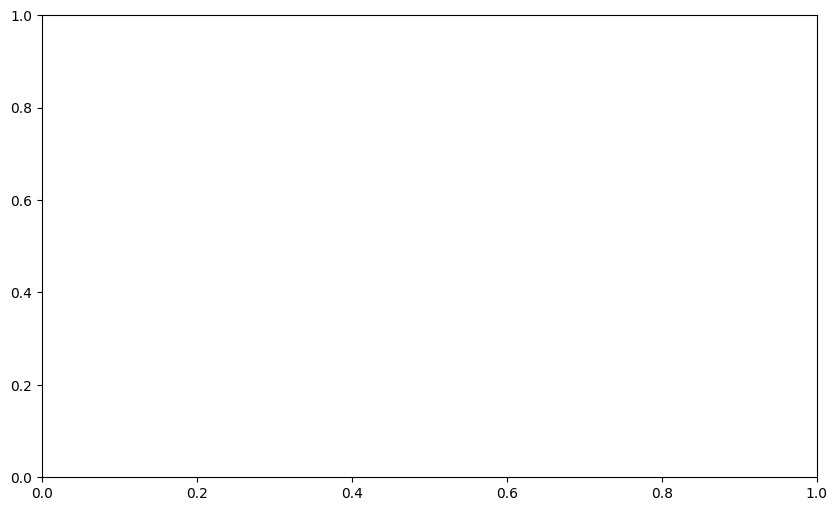

In [33]:
import matplotlib.pyplot as plt
from pypfopt import plotting

# Plot the efficient frontier
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Highlight key portfolios
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker='*', s=300, c='gold', label='Max Sharpe Ratio')

ef.min_volatility()
ret_min_vol, std_min_vol, _ = ef.portfolio_performance()
ax.scatter(std_min_vol, ret_min_vol, marker='*', s=300, c='green', label='Min Volatility')

# Formatting
ax.set_title('Efficient Frontier with Key Portfolios', pad=20)
ax.set_xlabel('Annualized Volatility (Risk)')
ax.set_ylabel('Annualized Return')
ax.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()